In [30]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# import os
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Colab Notebooks"
# %cd /content/gdrive/My Drive/Colab Notebooks

In [31]:
# # # uncomment this cell for first run to install the packages.
# !pip install quandl
# !pip install ta 
# !pip install pycaret
# !pip install kats
# !pip install git+https://github.com/ourownstory/neural_prophet.git
# !pip install -U prophet
# !pip install -U sklearn
# !pip install -U scikit-learn
# !pip install -U pmdarima


# !pip --version
# !pip install quandl
# !pip install  statsmodels
# !pip install pycaret
# !pip install kats
# !pip install -U sklearn
# !pip install -U scikit-learn
# !pip install -U sklearn
# !pip install ta 
# !pip install -U pmdarima

In [32]:
import numpy as np
import pandas as pd
import re
from math import sqrt
import quandl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
# for mean_squared_error set squared = False for RMSE, (y_true, y_pred)
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.statespace.varmax import VARMAX, VARMAXResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet
import random
import warnings
warnings.filterwarnings('ignore')

In [33]:
from pycaret.regression import *
import copy
# import plotly.express as px

In [34]:
from kats.consts import TimeSeriesData

In [35]:
pd.set_option('display.max_columns', None)

In [36]:
quandl.ApiConfig.api_key = "2At3atzXCrMx_BXfkyz7"
# 6b7jcHuxwW7Wot1kyFNS

### Data to be used

In [37]:
metadata = pd.read_csv('BSE_metadata.csv')
metadata.head()

,code,name,description,refreshed_at,from_date,to_date
0,BOM500002,ABB India Limited EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
1,BOM500003,AEGIS LOGISTICS LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
2,BOM500008,AMARA RAJA BATTERIES LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
3,BOM500009,AMBALAL SARABHAI ENTERPRISES LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
4,BOM500010,HOUSING DEVELOPMENT FINANCE CORP.LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,1/3/1992,1/18/2021


## Utility variables and functions

In [38]:
### Codes of selected stocks
healthcare = ['BOM524715','BOM532488','BOM500124']
banking = ['BOM500180','BOM532174','BOM500247']
metals = ['BOM500470','BOM500228','BOM500440']
auto = ['BOM532977','BOM500570','BOM532500']
it = ['BOM500209','BOM532540','BOM507685']
BSE_HEALTHCARE = 'SI0800'
BSE_Information_Technology = 'SI1000'
BSE_BANKEX = 'SIBANK'
BSE_METAL = 'SI1200'
BSE_AUTO = 'SI1900'
SENSEX = 'SENSEX'

stocks = healthcare+banking+metals + auto+it
indices = [BSE_HEALTHCARE, BSE_Information_Technology, BSE_BANKEX, BSE_METAL, BSE_AUTO, SENSEX]
allSymbols = stocks + indices
ScriptWiseData = {}

In [39]:
# Global Variables
RSIColumn = 'RSI'
ATRColumns = ['TR', 'ATR']
MACDColumns = ['FastAverage', 'SlowAverage','MACD','Signal']
BollBandColumns = ['BB_up',"BB_dn","MA","BB_width"]
ADXColumns = ['pos_directional_indicator', 'neg_directional_indicator', 'adx']
OnBalanceVolume = 'OBV'
TechnicalIndicators = ['RSI', 'ATR', 'MACD', 'adx', 'OBV'] #exogenous variables

AllIndicatorColumns = [RSIColumn]+ATRColumns+MACDColumns+BollBandColumns+ADXColumns+[OnBalanceVolume]

In [40]:
start_date = '2020-03-02'
end_date = '2021-03-23'

In [41]:
# get null values of all the stocks
def getNullValuesForSetOfStocks(stockCodeList = allSymbols):
    nullCounts = pd.DataFrame(ScriptWiseData[stockCodeList[0]].isnull().sum(), columns= [getStockNameFromStockCode(stockCodeList[0])])
    for symbol in stockCodeList[1:]:
        currNull = pd.DataFrame(ScriptWiseData[symbol].isnull().sum(), columns= [getStockNameFromStockCode(symbol)])
        nullCounts = nullCounts.merge(currNull, left_index=True, right_index = True, how='outer')
    return nullCounts

In [42]:
def adf_test(series, title = ''):
    """
    Pass in a time series and an optional title
    """
    result = sts.adfuller(series.dropna(), autolag = 'AIC')
    label = ['ADF test statistic', 'p-value', '# lags used', '#observations']
#     print(result)
    out = pd.Series(result[0:4], index=label)
    out['Stock Name'] = getStockNameFromStockCode(title)
    out['Stock Code'] = title
    for key, val in result[4].items():
        out[f'critical value ({key})'] = val
        
#     print(out)
    if(result[1]<0.05):
        return out, 'Stationary'
    else:
        return out, 'Non-Stationary'

In [43]:
stockMetadata = metadata[metadata['code'].isin(allSymbols)]
stockMetadata.head()

,code,name,description,refreshed_at,from_date,to_date
70,BOM500124,DR.REDDY'S LABORATORIES LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021
104,BOM500180,HDFC Bank Ltd EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/26/1995,1/18/2021
121,BOM500209,INFOSYS LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021
133,BOM500228,JSW STEEL LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021
146,BOM500247,KOTAK MAHINDRA BANK LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021


In [44]:
print(stockMetadata.shape)
print(stockMetadata[stockMetadata['code'].isin(stocks)].shape)
print(stockMetadata[stockMetadata['code'].isin(indices)].shape)

(21, 6)
(15, 6)
(6, 6)


## Map Index to  stocks

In [45]:
stockMetadata.loc[:, 'isStock'] = 0
stockMetadata.loc[:, 'Index'] = ''

stockMetadata.loc[stockMetadata['code'].isin(stocks), 'isStock'] = 1
stockMetadata.reset_index(inplace=True)

In [46]:
stockMetadata.loc[stockMetadata['code'].isin(healthcare), 'Index'] = BSE_HEALTHCARE
stockMetadata.loc[stockMetadata['code'].isin(banking), 'Index'] = BSE_BANKEX
stockMetadata.loc[stockMetadata['code'].isin(metals), 'Index'] = BSE_METAL
stockMetadata.loc[stockMetadata['code'].isin(auto), 'Index'] = BSE_AUTO
stockMetadata.loc[stockMetadata['code'].isin(it), 'Index'] = BSE_Information_Technology

In [47]:
stockMetadata.head()

,index,code,name,description,refreshed_at,from_date,to_date,isStock,Index
0,70,BOM500124,DR.REDDY'S LABORATORIES LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,3/2/1992,1/18/2021,1,SI0800
1,104,BOM500180,HDFC Bank Ltd EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/26/1995,1/18/2021,1,SIBANK
2,121,BOM500209,INFOSYS LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021,1,SI1000
3,133,BOM500228,JSW STEEL LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021,1,SI1200
4,146,BOM500247,KOTAK MAHINDRA BANK LTD. EOD Prices,End of Day prices and additional trading infor...,1/19/2021 14:15,5/2/1995,1/18/2021,1,SIBANK


In [48]:
stockMetadata['isStock'].value_counts()

1    15
0     6
Name: isStock, dtype: int64

## Code to download the data from quandl. 

In [49]:
# # download the required data - needed only 1 time
# i=0
# code = f'BSE/{stockMetadata.loc[i, "code"]}'
# dataset = quandl.get(code, start_date='2000-01-01', end_date='2021-03-23').sort_values(by='Date', ascending=True)
# dataset['StockName']=stockMetadata.loc[i, 'name']
# dataset['code'] = stockMetadata.loc[i, "code"]
# dataset['isStock'] = stockMetadata.loc[i, "isStock"]
# dataset['Index'] = stockMetadata.loc[i, "Index"]
# for i in range(1, len(stockMetadata)):
#     code = f'BSE/{stockMetadata.loc[i, "code"]}'
#     temp = quandl.get(code, start_date='2000-01-01', end_date='2021-03-23').sort_values(by='Date', ascending=True)
#     temp['StockName']=stockMetadata.loc[i, 'name']
#     temp['code'] = stockMetadata.loc[i, "code"]
#     temp['isStock'] = stockMetadata.loc[i, "isStock"]
#     temp['Index'] = stockMetadata.loc[i, "Index"]
# #     print( stockMetadata.loc[i, "Index"])
#     dataset = dataset.append(temp)
# dataset.to_csv('data.csv')
# dataset.head()

In [50]:
# dataset = pd.read_csv('data.csv')
# dataset.head()
#-----------------------
dataset = pd.read_csv('TimeSeriesData.csv')
dataset.head()

,Date,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O,StockName,code,isStock,Index
0,2000-01-03,1500.0,1557.35,1500.00,1557.35,1544.195154,82330.0,945.0,127133587.0,NaN,NaN,57.35,57.35,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
1,2000-01-04,1601.0,1681.00,1527.00,1647.25,1621.040930,210676.0,3308.0,341514419.0,NaN,NaN,154.00,46.25,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2,2000-01-05,1600.0,1648.00,1515.50,1559.00,1590.903923,205669.0,2707.0,327199619.0,NaN,NaN,132.50,-41.00,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
3,2000-01-06,1582.0,1683.70,1560.00,1683.70,1623.244182,161085.0,2559.0,261480289.0,NaN,NaN,123.70,101.70,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
4,2000-01-07,1718.0,1718.00,1549.05,1549.05,1593.853264,120952.0,1955.0,192779740.0,NaN,NaN,168.95,-168.95,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800


In [51]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105449 entries, 0 to 105448
Data columns (total 17 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   Date                       105449 non-null  object 
 1   Open                       95130 non-null   float64
 2   High                       95130 non-null   float64
 3   Low                        95130 non-null   float64
 4   Close                      105449 non-null  float64
 5   WAP                        74255 non-null   float64
 6   No. of Shares              74255 non-null   float64
 7   No. of Trades              74255 non-null   float64
 8   Total Turnover             74255 non-null   float64
 9   Deliverable Quantity       68110 non-null   float64
 10  % Deli. Qty to Traded Qty  68110 non-null   float64
 11  Spread H-L                 74255 non-null   float64
 12  Spread C-O                 74255 non-null   float64
 13  StockName                  10

### Verify the min and max of dates of all selected stocks and indices

In [52]:
dateRanges = dataset.groupby(['code', 'StockName']).agg({'Date': ['min', 'max']}).reset_index()
dateRanges.columns = ['Stock Code', 'Stock Name', 'First Date', 'Last Date']
len(dateRanges)

21

In [53]:
# use above ranges to get stockName
def getStockNameFromStockCode(stockCode):
    return dateRanges.loc[dateRanges['Stock Code']==stockCode, 'Stock Name'].values[0];

In [54]:
data = dataset.set_index('Date')
data.head()

,Open,High,Low,Close,WAP,No. of Shares,No. of Trades,Total Turnover,Deliverable Quantity,% Deli. Qty to Traded Qty,Spread H-L,Spread C-O,StockName,code,isStock,Index
Date,,,,,,,,,,,,,,,,
2000-01-03,1500.0,1557.35,1500.00,1557.35,1544.195154,82330.0,945.0,127133587.0,NaN,NaN,57.35,57.35,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2000-01-04,1601.0,1681.00,1527.00,1647.25,1621.040930,210676.0,3308.0,341514419.0,NaN,NaN,154.00,46.25,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2000-01-05,1600.0,1648.00,1515.50,1559.00,1590.903923,205669.0,2707.0,327199619.0,NaN,NaN,132.50,-41.00,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2000-01-06,1582.0,1683.70,1560.00,1683.70,1623.244182,161085.0,2559.0,261480289.0,NaN,NaN,123.70,101.70,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800
2000-01-07,1718.0,1718.00,1549.05,1549.05,1593.853264,120952.0,1955.0,192779740.0,NaN,NaN,168.95,-168.95,DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,1,SI0800


### Populate dictionary to hold individual Stock Data

In [55]:
# ScriptWiseData = {'Symbol1': <DatqaFrame>, 'Suymbol 2':Dataframe2}
for symbol in allSymbols:
    ScriptWiseData[symbol] = data.loc[data.code==symbol]

### View null values in the data 

In [56]:
getNullValuesForSetOfStocks()

,SUN PHARMACEUTICAL INDUSTRIES LTD. EOD Prices,DIVI'S LABORATORIES LTD. EOD Prices,DR.REDDY'S LABORATORIES LTD. EOD Prices,HDFC Bank Ltd EOD Prices,ICICI BANK LTD. EOD Prices,KOTAK MAHINDRA BANK LTD. EOD Prices,TATA STEEL LTD. EOD Prices,JSW STEEL LTD. EOD Prices,HINDALCO INDUSTRIES LTD. EOD Prices,BAJAJ AUTO LTD. EOD Prices,TATA MOTORS LTD. EOD Prices,MARUTI SUZUKI INDIA LTD. EOD Prices,INFOSYS LTD. EOD Prices,TATA CONSULTANCY SERVICES LTD. EOD Prices,WIPRO LTD. EOD Prices,BSE Healthcare,BSE Information Technology,BSE BANKEX,BSE METAL,BSE AUTO,BSE SENSEX
Open,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3810,3810,369,1165,1165,0
High,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3810,3810,369,1165,1165,0
Low,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3810,3810,369,1165,1165,0
Close,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
WAP,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282
No. of Shares,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282
No. of Trades,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282
Total Turnover,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282
Deliverable Quantity,548,57,538,538,544,537,545,580,555,1,542,81,539,2,538,5282,5282,4784,5282,5282,5282
% Deli. Qty to Traded Qty,548,57,538,538,544,537,545,580,555,1,542,81,539,2,538,5282,5282,4784,5282,5282,5282


# Deriving Technical indicators 

### MACD

In [57]:
# function to create data MACD signal and data. 
def MACD(df, span1 = 12, span2= 26, span3 = 9):
    stockData = df.copy()
    stockData['FastAverage'] = stockData['Close'].ewm(span = span1, min_periods = span1).mean()
    stockData['SlowAverage'] = stockData['Close'].ewm(span = span2, min_periods = span2).mean()
    stockData['MACD'] = stockData['FastAverage'] - stockData['SlowAverage']
    stockData['Signal'] = stockData['MACD'].ewm(span=span3, min_periods = span3).mean()
    return stockData[MACDColumns]

In [58]:
# create stock code based dataframes with MACD signal
for symbol in allSymbols:
    macd = MACD(ScriptWiseData[symbol])
    ScriptWiseData[symbol] = ScriptWiseData[symbol].merge(macd, left_index=True, right_index = True, how='left')

### RSI - Relative Strength Index

In [59]:
# Calculating RSI without using loop
def RSI(DF, n=14):
    df =  DF.copy()
    "function to calculate RSI"
    delta = df['Close'].diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[n-1]] = np.mean( u[:n]) # first value is average of gains
    u = u.drop(u.index[:(n-1)])
    d[d.index[n-1]] = np.mean( d[:n]) # first value is average of losses
    d = d.drop(d.index[:(n-1)])
    rs = u.ewm(com=n,min_periods=n).mean()/d.ewm(com=n,min_periods=n).mean()
    rsi = 100 - 100 / (1+rs);
    return pd.DataFrame(rs).rename(columns={'Close':'RSI'})

In [60]:
#RSI 
for symbol in allSymbols:   
    rsi = RSI(data.loc[data.code==symbol])
    ScriptWiseData[symbol] = ScriptWiseData[symbol].merge(rsi, left_index=True, right_index = True, how='left')

### ATR

In [61]:
def ATR(DF,n=20):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    return df2[ATRColumns]

In [62]:
#ATR 
for symbol in allSymbols:
    ScriptWiseData[symbol][ATRColumns] = ATR(data.loc[data.code==symbol])

### Bollinger band

In [63]:
def BollBnd(DF,n=14):
    "function to calculate Bollinger Band"
    df = DF.copy()
    df["MA"] = df['Close'].rolling(n).mean()
    df["BB_up"] = df["MA"] + 2*df['Close'].rolling(n).std(ddof=0) #ddof=0 is required since we want to take the standard deviation of the population and not sample
    df["BB_dn"] = df["MA"] - 2*df['Close'].rolling(n).std(ddof=0) #ddof=0 is required since we want to take the standard deviation of the population and not sample
    df["BB_width"] = df["BB_up"] - df["BB_dn"]
#     df.dropna(inplace=True)
    return df[BollBandColumns]

In [64]:
#Boll band
for symbol in allSymbols:
    ScriptWiseData[symbol][BollBandColumns] = BollBnd(data.loc[data.code==symbol])

### OBV

In [65]:
def OBV(DF):
    """function to calculate On Balance Volume"""
    df = DF.copy()
    df['daily_ret'] = df['Close'].pct_change()
    df['direction'] = np.where(df['daily_ret']>=0,1,-1)
    df['direction'][0] = 0
    df['vol_adj'] = df['No. of Shares'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']

In [66]:
#OBV
for symbol in allSymbols:
    ScriptWiseData[symbol]['OBV'] = OBV(data.loc[data.code==symbol])

### ADX

In [67]:
from ta.trend import ADXIndicator
def ADX(DF):
    df = DF.copy()
    adxI = ADXIndicator(df['High'],df['Low'],df['Close'],14,False)
    df['pos_directional_indicator'] = adxI.adx_pos()
    df['neg_directional_indicator'] = adxI.adx_neg()
    df['adx'] = adxI.adx()
    return df[ADXColumns]

In [68]:
# ADX
for symbol in allSymbols:
    ScriptWiseData[symbol][ADXColumns] = ADX(data.loc[data.code==symbol])

# Removing Extra Columms

In [72]:
OriginalScriptWiseData = ScriptWiseData
for symbol in allSymbols:
    ScriptWiseData[symbol] = ScriptWiseData[symbol][['Close']+TechnicalIndicators]

## Dropping null values

In [73]:
# drop rows from the stock whose technical indicator values are null. 
for stock in stocks:
#     ScriptWiseData[stock] = ScriptWiseData[stock].dropna(subset=AllIndicatorColumns)
    ScriptWiseData[stock] = ScriptWiseData[stock].dropna()    

In [74]:
# ScriptWiseData['BOM500180'][ScriptWiseData['BOM500180']['MACD'].isna()]
getNullValuesForSetOfStocks()

,SUN PHARMACEUTICAL INDUSTRIES LTD. EOD Prices,DIVI'S LABORATORIES LTD. EOD Prices,DR.REDDY'S LABORATORIES LTD. EOD Prices,HDFC Bank Ltd EOD Prices,ICICI BANK LTD. EOD Prices,KOTAK MAHINDRA BANK LTD. EOD Prices,TATA STEEL LTD. EOD Prices,JSW STEEL LTD. EOD Prices,HINDALCO INDUSTRIES LTD. EOD Prices,BAJAJ AUTO LTD. EOD Prices,TATA MOTORS LTD. EOD Prices,MARUTI SUZUKI INDIA LTD. EOD Prices,INFOSYS LTD. EOD Prices,TATA CONSULTANCY SERVICES LTD. EOD Prices,WIPRO LTD. EOD Prices,BSE Healthcare,BSE Information Technology,BSE BANKEX,BSE METAL,BSE AUTO,BSE SENSEX
Close,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
RSI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,27,27,27,27,27
ATR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3829,3829,388,1184,1184,20
MACD,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,25,25,25,25,25
adx,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5255,5255,4757,5255,5255,0
OBV,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5282,5282,4784,5282,5282,5282


# ADF Test for closing price

In [75]:
stock = stocks[0]
adf_testResult = pd.DataFrame(adf_test(ScriptWiseData[stocks[0]].Close, stocks[0])[0], columns = ['Value']).transpose().set_index(['Stock Name', 'Stock Code'])
for i in range(1, len(stocks)):
    res = pd.DataFrame(adf_test(ScriptWiseData[stocks[i]].Close, stocks[i])[0], columns = ['Value']).transpose().set_index(['Stock Name', 'Stock Code'])
    adf_testResult = adf_testResult.append(res)
adf_testResult['Result'] = adf_testResult['p-value'].apply(lambda x: 'Stationary' if x<0.05 else 'Non-Stationary')
# adf_testResult.to_csv('Outputs/adfTest.csv')
adf_testResult.head()

,,ADF test statistic,p-value,# lags used,#observations,critical value (1%),critical value (5%),critical value (10%),Result
Stock Name,Stock Code,,,,,,,,
SUN PHARMACEUTICAL INDUSTRIES LTD. EOD Prices,BOM524715,-5.02575,1.97306e-05,0,5253,-3.4316,-2.86209,-2.56706,Stationary
DIVI'S LABORATORIES LTD. EOD Prices,BOM532488,-3.57137,0.0063325,32,4424,-3.43183,-2.86219,-2.56712,Stationary
DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,-0.0817256,0.951229,28,5226,-3.4316,-2.86209,-2.56706,Non-Stationary
HDFC Bank Ltd EOD Prices,BOM500180,-2.22396,0.197665,0,5254,-3.4316,-2.86209,-2.56706,Non-Stationary
ICICI BANK LTD. EOD Prices,BOM532174,-2.65894,0.0814161,1,5252,-3.4316,-2.86209,-2.56706,Non-Stationary


# Train test and validation split

In [76]:
def TrainTestSplitByDateRange(df,test_start_date = '2020-03-02',test_end_date = '2021-03-23'):
    train = df.loc[:test_start_date]
    test = df.loc[test_start_date:test_end_date]
    return train, test[1:]

#ARIMA for Closing Values 

### AutoARIMA DataFrame


In [77]:
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

In [78]:
AutoArimaResults = pd.DataFrame(columns=['p Closing Values', 'd Closing Values', 'q Closing Values','p N Closing Values', 'd N Closing Values', 'q N Closing Values','p Closing Percentage', 'd Closing Percentage', 'q Closing Percentage'], index = stocks)

In [126]:
def CalculateAutoArima(stockcode, data, parameter ,p ,d,q):
    if(AutoArimaResults.loc[:, [p, d, q]].isnull().sum(axis=1)[stockcode] > 0):
        params = auto_arima(data[parameter], maxiter = 1000)
        AutoArimaResults.loc[stockcode, [p,d,q]] = params.order
        return params.order
    else:
        return tuple(AutoArimaResults.loc[stockcode, [p, d, q]])

In [ ]:
AutoArimaResults

In [171]:
AutoArimaResults.to_csv('Outputs/AutoArimaResults.csv')

### Common Functions

In [81]:
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARMAResults, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.tools import diff
from statsmodels.tools.eval_measures import rmse


In [152]:
def errorEvaluation(actual, pred):
  RMSE = str(mean_squared_error(actual, pred, squared=False))
  MAPE = str(mean_absolute_percentage_error(actual,pred))
  R2 = str(r2_score(actual,pred))
  Noise = float(pred.diff().abs().mean())
  return [RMSE, MAPE, R2, Noise]

In [83]:
def modified_prediction_frame(_df_pred, index):
  _df_pred = _df_pred.to_frame()
  _df_pred['Date'] = index
  pd.to_datetime(_df_pred['Date'])
  _df_pred.set_index('Date', inplace=True)
  _df_pred.rename(columns={0 : 'Predicted'}, inplace=True)
  return _df_pred

### Steps to calculate ARIMA Model (Closing Prices)

In [84]:
stockcode = 'BOM532540'
train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stockcode])
start = len(train_data)
end = len(train_data) + len(test_data) - 1

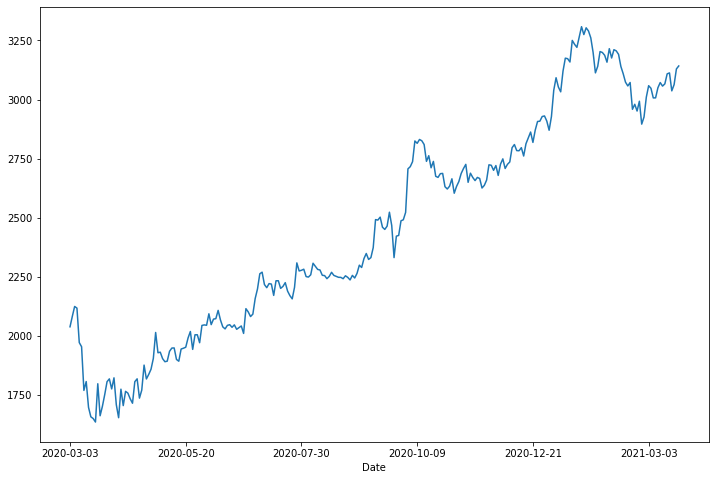

In [85]:
test_data.Close.plot(figsize = (12,8))

In [86]:
e = adf_test(ScriptWiseData['BOM532540'].Close, title=stockcode)
print(e)

(ADF test statistic                                       -1.53596
p-value                                                  0.515653
# lags used                                                     0
#observations                                                4087
Stock Name              TATA CONSULTANCY SERVICES LTD. EOD Prices
Stock Code                                              BOM532540
critical value (1%)                                      -3.43195
critical value (5%)                                      -2.86225
critical value (10%)                                     -2.56715
dtype: object, 'Non-Stationary')


In [87]:
CalculateAutoArima(stockcode=stockcode,data= ScriptWiseData[stockcode],parameter = 'Close', p= 'p Closing Values',d = 'd Closing Values', q = 'q Closing Values')

(2, 1, 2)

In [89]:
model = ARIMA(train_data.Close, order = (2,1,2))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Close   No. Observations:                 3823
Model:                 ARIMA(2, 1, 2)   Log Likelihood              -19845.947
Method:                       css-mle   S.D. of innovations             43.478
Date:                Wed, 21 Jul 2021   AIC                          39703.895
Time:                        07:39:16   BIC                          39741.387
Sample:                             1   HQIC                         39717.215
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.2491      0.396      0.630      0.529      -0.526       1.025
ar.L1.D.Close     0.2412      0.301      0.801      0.423      -0.349       0.831
ar.L2.D.Close     0.7014      0.294      2.384      0.017       0.125       1.278
ma.L1.D.Close    -0.2330      0.291     -0.802      0.423      -0.803       0.337
ma.L2.D.Close    -0.7348      0.287     -2.560      0.010      -1.297      -0.172
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0344           +0.0000j            1.0344            0.0000
AR.2           -1.3783           +0.0000j            1.3783            0.5000
MA.1            1.0187           +0.0000j            1.0187            0.0000
MA.2           -1.3358           +0.0000j            1.3358            0.5000
-----------------------------------------------------------------------------
"""

In [90]:
predictions = results.predict(start = start, end = end, typ ='levels').rename('Arima(2,1,2) Predictions')
predictions = modified_prediction_frame(predictions, test_data.Close.index)

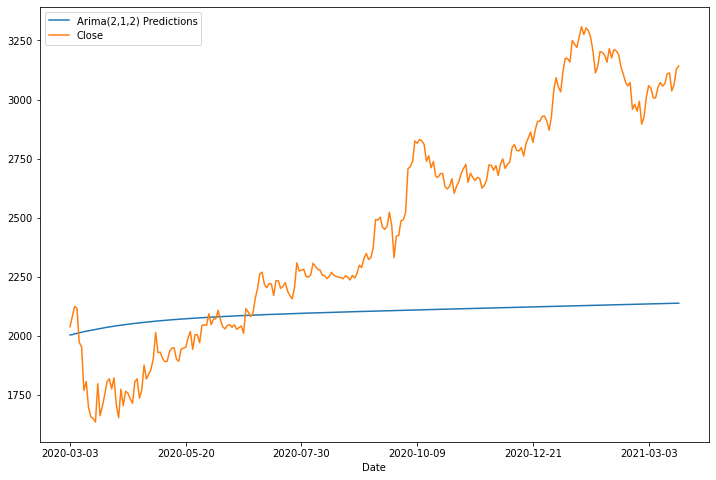

In [91]:
predictions.plot(legend = True, figsize = (12,8))
test_data.Close.plot(legend = True)

In [92]:
print(errorEvaluation(test_data.Close, predictions))
print('-----------')
print(predictions.describe())
print('-----------')
print(test_data.Close.describe())

['569.607308020981', '0.16728353480157496', '-0.48346830618458214']
-----------
       Arima(2,1,2) Predictions
count                264.000000
mean                2098.166211
std                   31.374164
min                 2004.739424
25%                 2082.190225
50%                 2105.259643
75%                 2122.360939
max                 2138.818245
-----------
count     264.000000
mean     2459.927273
std       468.554923
min      1636.100000
25%      2047.575000
50%      2361.325000
75%      2827.037500
max      3308.200000
Name: Close, dtype: float64


### Generic Function For ARIMA Closing Prices

In [146]:
def ARIMA_Model_Generic(StockCode, data, feature, Results, Order, train_data, test_data):
  print("Modeling for the Stock: {}".format(StockCode))

  start = len(train_data)
  end = len(train_data) + len(test_data) - 1
  
  print("ADF Test for the given series.")
  adf, Stationarity = adf_test(train_data[feature], title=StockCode)
  print(adf)
  print('----------------------------------------------------------------------------')
  Results.loc[StockCode,'Stationarity'] = Stationarity

  model = ARIMA(train_data[feature], order = Order)
  results = model.fit()
  print(results.params)
  print("Order: " + str(Order) )
  print('---------------------------------------------------------------------------')
  Results.loc[StockCode, 'Order'] = str(Order)

  predictions = results.predict(start = start, end = end, typ ='levels')
  predictions = modified_prediction_frame(predictions, test_data[feature].index)

  errorEval = errorEvaluation(test_data[feature], predictions)
  RMSE = errorEval[0]
  MAPE = errorEval[1]
  R2   = errorEval[2]
  Noise = errorEval[3]

  Results.loc[StockCode, ['RMSE', 'MAPE', 'R2', 'Noise']] = errorEval
  print("RMSE: {0} \nMape: {1} \nR2: {2} \nNoise: {3}".format(RMSE, MAPE, R2, Noise))
  print('---------------------------------------------------------------------------')
  
  print('Description of the Predicted Data')
  print(predictions.describe())
  pred_mean = predictions.mean(numeric_only=True)
  Results.loc[StockCode, 'Predictions Mean'] = str(float(pred_mean))
  print('---------------------------------------------------------------------------')

  print('Description of the Actual Data')
  print(test_data[feature].describe())
  Results.loc[StockCode, 'Actual Mean'] = str(test_data[feature].mean())
  return predictions


In [148]:
ArimaModelPricesResults = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2', 'Noise', 'Predictions Mean', 'Actual Mean'], index = stocks)

In [ ]:
ArimaModelPricesResults

In [ ]:
count  = 1
for stock in stocks:
  print("Working for Stock {0} - {1}".format(count, stock))
  train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
  feature = 'Close'
  Order = CalculateAutoArima(stock, train_data, feature,  p= 'p Closing Values',d = 'd Closing Values', q = 'q Closing Values')
  ARIMA_Model_Generic(StockCode = stock, data = ScriptWiseData, feature = feature, Results=ArimaModelPricesResults, Order=Order, train_data=train_data, test_data=test_data)
  count += 1

In [158]:
ArimaModelPricesResults.to_csv('Outputs/ArimaModelPricesResults.csv')

# ARIMA for Normalized Closing Price

### Normalizing the Values  - Normalized_Prices

In [105]:
for stock in stocks:
  benchmark_prices = ScriptWiseData[stock].Close.iloc[0]
  ScriptWiseData[stock]['Normalized_prices'] = ScriptWiseData[stock].Close.div(benchmark_prices).mul(100)


In [106]:
ScriptWiseData[stockcode].head()

,Close,RSI,ATR,MACD,adx,OBV,Normalized_prices
Date,,,,,,,
2004-10-01,1048.25,1.781982,17.4850,8.086665,27.865725,485611.0,100.000000
2004-10-04,1076.80,2.653364,18.5375,11.022214,29.406966,1101096.0,102.723587
2004-10-05,1080.20,2.764549,18.9275,13.432900,31.082611,1861397.0,103.047937
2004-10-06,1081.15,2.797834,19.8775,15.229562,33.012967,2677803.0,103.138564
2004-10-07,1096.75,3.383456,19.8075,17.605517,34.805440,3134018.0,104.626759


### Generic Function For ARIMA Normalized Closing Prices

In [160]:
ArimaModelPricesResults_Norm = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2','Noise', 'Predictions Mean', 'Actual Mean'], index = stocks)

In [163]:
ArimaModelPricesResults_Norm

,Stationarity,Order,RMSE,MAPE,R2,Noise,Predictions Mean,Actual Mean
BOM524715,Stationary,"(0, 1, 1)",9.840667840222995,0.355410507284823,-8.455269878122396,0.0160697,15.058929040967984,23.898785180601884
BOM532488,Stationary,"(1, 1, 3)",378.51689407728094,0.2511306914218209,-1.6284635599878694,0.174736,828.4724386784924,1135.271146928369
BOM500124,Non-Stationary,"(1, 1, 0)",112.4162925947895,0.31945270102370793,-5.202358751943313,0.0211798,207.3283057523124,310.8216083092408
BOM500180,Non-Stationary,"(0, 1, 0)",85.90778824958659,0.1671348090917258,0.1094444686026882,0.0759599,481.0407877409971,474.62988953277795
BOM532174,Non-Stationary,"(2, 1, 1)",75.96159604613452,0.30417590952631507,-0.634926707346976,0.0452992,303.7344853481212,253.28486537418775
BOM500247,Non-Stationary,"(1, 1, 2)",170.65058663035194,0.19157830495635045,-0.0258187486830046,0.168675,963.459645930307,898.6878859159065
BOM500470,Non-Stationary,"(2, 1, 2)",123.97824343193683,0.2473321230355609,-0.233897150217236,0.067987,261.29915024703746,319.48856943998294
BOM500228,Non-Stationary,"(0, 1, 0)",1737.8534852439002,0.2863235200322028,-0.1300941445128383,0.841188,4383.2756190859445,5122.0971074380195
BOM500440,Non-Stationary,"(0, 1, 0)",11.688656501996444,0.3395597719612758,-1.2217363599653286,0.0172185,15.664650952644486,23.029191616766475
BOM532977,Non-Stationary,"(1, 1, 2)",104.34617421075605,0.10759885284420434,0.17055365401018163,0.220525,651.5622569084582,675.0404380524164


In [ ]:
count  = 1
for stock in stocks:
  print("Working for Stock {0} - {1}".format(count, stock))
  train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
  feature = 'Normalized_prices'
  Order = CalculateAutoArima(stock, train_data, feature,'p N Closing Values', 'd N Closing Values', 'q N Closing Values')
  ARIMA_Model_Generic(StockCode= stock, data = ScriptWiseData, feature = feature, Results=ArimaModelPricesResults_Norm, Order=Order, train_data=train_data, test_data=test_data)
  count += 1

In [164]:
ArimaModelPricesResults_Norm.to_csv('Outputs/ArimaModelPricesResults_Norm.csv')

# ARIMA Model For Returns

### Convert Closing price to percentage change

In [139]:
for s in stocks:
    ScriptWiseData[s]['Stock_Returns'] = ScriptWiseData[s].Close.pct_change(1).mul(100)
    ScriptWiseData[s] = ScriptWiseData[s][1:] # Because of NAN first value
    

In [140]:
stock = stocks[0]
adf_testResult = pd.DataFrame(adf_test(ScriptWiseData[stocks[0]].Stock_Returns, stocks[0])[0], columns = ['Value']).transpose().set_index(['Stock Name', 'Stock Code'])
for i in range(1, len(stocks)):
    res = pd.DataFrame(adf_test(ScriptWiseData[stocks[i]].Stock_Returns, stocks[i])[0], columns = ['Value']).transpose().set_index(['Stock Name', 'Stock Code'])
    adf_testResult = adf_testResult.append(res)
adf_testResult['Result'] = adf_testResult['p-value'].apply(lambda x: 'Stationary' if x<0.05 else 'Non-Stationary')
# adf_testResult.to_csv('Outputs/adfTestReturns.csv')
adf_testResult.to_csv('Outputs/adfTestReturns.csv')
adf_testResult.head()

,,ADF test statistic,p-value,# lags used,#observations,critical value (1%),critical value (5%),critical value (10%),Result
Stock Name,Stock Code,,,,,,,,
SUN PHARMACEUTICAL INDUSTRIES LTD. EOD Prices,BOM524715,-51.4892,0,1,5251,-3.4316,-2.86209,-2.56706,Stationary
DIVI'S LABORATORIES LTD. EOD Prices,BOM532488,-13.9231,5.2515e-26,23,4432,-3.43183,-2.86219,-2.56712,Stationary
DR.REDDY'S LABORATORIES LTD. EOD Prices,BOM500124,-71.6184,0,0,5253,-3.4316,-2.86209,-2.56706,Stationary
HDFC Bank Ltd EOD Prices,BOM500180,-54.5808,0,1,5252,-3.4316,-2.86209,-2.56706,Stationary
ICICI BANK LTD. EOD Prices,BOM532174,-32.1268,0,5,5247,-3.4316,-2.86209,-2.56706,Stationary


### Generic Function For ARIMA Returns

In [165]:
ArimaModelPricesResults_Returns = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2', 'Noise', 'Predictions Mean', 'Actual Mean'], index = stocks)

In [168]:
ArimaModelPricesResults_Returns

,Stationarity,Order,RMSE,MAPE,R2,Noise,Predictions Mean,Actual Mean
BOM524715,Stationary,"(1, 0, 2)",2.4181118974092795,1.0166106322689497,-0.005037811113121293,0.000627387,0.030466553360277676,0.20573864798210306
BOM532488,Stationary,"(3, 0, 1)",2.3717917550962846,1.4388318423470836,-0.0027097732494432147,0.000307748,0.10621080225578923,0.22024935679929103
BOM500124,Stationary,"(0, 0, 0)",2.2544614582901135,1.0323544377004528,-0.003719389307451193,0,0.04364491996344812,0.18088231861858162
BOM500180,Stationary,"(1, 0, 1)",2.6519151836024393,1.0231225623961286,-0.0008562222694545873,0.00032133,0.07198783460964911,0.12566854955618048
BOM532174,Stationary,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500247,Stationary,"(0, 0, 1)",2.9141169546677324,1.0627084569026468,-8.850868569409975e-05,0.000186636,0.10389020263388045,0.0901047802483421
BOM500470,Stationary,"(2, 0, 2)",3.1101847428760556,1.0106860272280953,-0.00788677036549501,0.00350139,0.05643173958385892,0.3173045225208098
BOM500228,Stationary,"(0, 0, 0)",3.11692590400075,1.6278397989659887,-0.00572148563224073,0,0.5238747004730313,0.2887804435159547
BOM500440,Stationary,"(2, 0, 2)",3.6821491769069343,0.9859135764449248,-0.009147224073579041,0.00181664,0.027242718093646,0.36871118873150094
BOM532977,Stationary,"(0, 0, 1)",2.434276173512719,1.173897888235235,0.0006579710679214257,0.000842997,0.08611715967783007,0.13360405849851478


In [ ]:
count  = 1
for stock in stocks:
  try:
    print("Working for Stock {0} - {1}".format(count, stock))
    train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
    feature = 'Stock_Returns'
    Order = CalculateAutoArima(stock, train_data, feature, p = 'p Closing Percentage', d = 'd Closing Percentage', q = 'q Closing Percentage')
    ARIMA_Model_Generic(StockCode= stock, data = ScriptWiseData, feature = feature, Results=ArimaModelPricesResults_Returns, Order=Order, train_data=train_data, test_data=test_data)
  except Exception as e:
    print(e)  
  count += 1

In [169]:
ArimaModelPricesResults_Returns.to_csv('Outputs/ArimaModelPricesResults_Returns.csv')

# Stats models basic ARIMA

In [207]:
len(ScriptWiseData['BOM524715'].Close) == len(ScriptWiseData['BOM524715'].RSI)

True

In [219]:
def ARIMAX_Model_Generic(StockCode, data, feature, Results, Order, train_data, test_data):
  print("Modeling for the Stock: {}".format(StockCode))

  start = len(train_data)
  end = len(train_data) + len(test_data) - 1
  
  print("ADF Test for the given series.")
  adf, Stationarity = adf_test(train_data[feature], title=StockCode)
  print(adf)
  print('----------------------------------------------------------------------------')
  Results.loc[StockCode,'Stationarity'] = Stationarity

  if len(train_data.RSI) != len(train_data[feature]):
    print("haaaye haaaye")
  model = ARIMA(endog = train_data[feature], exog = [train_data.RSI] , order = Order)
  results = model.fit()
  print(results.params)
  print("Order: " + str(Order) )
  print('---------------------------------------------------------------------------')
  Results.loc[StockCode, 'Order'] = str(Order)

  predictions = results.predict(start = start, end = end, typ ='levels')
  predictions = modified_prediction_frame(predictions, test_data[feature].index)

  errorEval = errorEvaluation(test_data[feature], predictions)
  RMSE = errorEval[0]
  MAPE = errorEval[1]
  R2   = errorEval[2]
  Noise = errorEval[3]

  Results.loc[StockCode, ['RMSE', 'MAPE', 'R2', 'Noise']] = errorEval
  print("RMSE: {0} \nMape: {1} \nR2: {2} \nNoise: {3}".format(RMSE, MAPE, R2, Noise))
  print('---------------------------------------------------------------------------')
  
  print('Description of the Predicted Data')
  print(predictions.describe())
  pred_mean = predictions.mean(numeric_only=True)
  Results.loc[StockCode, 'Predictions Mean'] = str(float(pred_mean))
  print('---------------------------------------------------------------------------')

  print('Description of the Actual Data')
  print(test_data[feature].describe())
  Results.loc[StockCode, 'Actual Mean'] = str(test_data[feature].mean())
  return predictions


In [213]:
ArimaxModelPricesResults = pd.DataFrame(columns=['Stationarity', 'Order', 'RMSE', 'MAPE', 'R2', 'Noise', 'Predictions Mean', 'Actual Mean'], index = stocks)

In [214]:
ArimaxModelPricesResults

,Stationarity,Order,RMSE,MAPE,R2,Noise,Predictions Mean,Actual Mean
BOM524715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM532488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500124,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM532174,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500247,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500470,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM500440,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BOM532977,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
count  = 1
for stock in stocks:
  print("Working for Stock {0} - {1}".format(count, stock))
  train_data, test_data = TrainTestSplitByDateRange(ScriptWiseData[stock])
  feature = 'Close'
  Order = CalculateAutoArima(stock, train_data, feature,  p= 'p Closing Values',d = 'd Closing Values', q = 'q Closing Values')
  ARIMAX_Model_Generic(StockCode = stock, data = ScriptWiseData, feature = feature, Results=ArimaModelPricesResults, Order=Order, train_data=train_data, test_data=test_data)
  break
  count += 1

In [ ]:
ArimaModelPricesResults.to_csv('Outputs/ArimaModelPricesResults.csv')

In [ ]:
def ARIMAXProcedure(stockCode):
    dataSet = ScriptWiseData[stockCode]
    train, test = TrainTestSplitByDateRange(dataSet)
    ARIMAXModel = ARIMA(dataSet.Close, exog = dataSet[TechnicalIndicators], order = CalculateAutoArima('BOM500180', dataSet))
    ARIMAXModel = ARIMAXModel.fit()
    df_pred = ARIMAXModel.predict(start = start_date, end = end_date, exog = test[TechnicalIndicators])
    return ARIMAXModel, df_pred

In [ ]:
ARIMAXModel, df_pred = ARIMAXProcedure(stocks[1])
residual = ARIMAXModel.resid

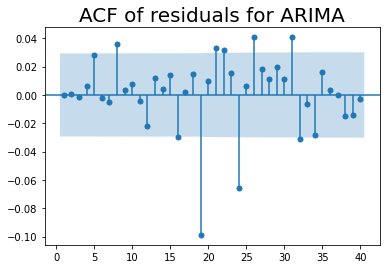

In [ ]:
sgt.plot_acf(residual[1:], zero=False, lags = 40)
plt.title("ACF of residuals for ARIMA", size =20)
plt.show()

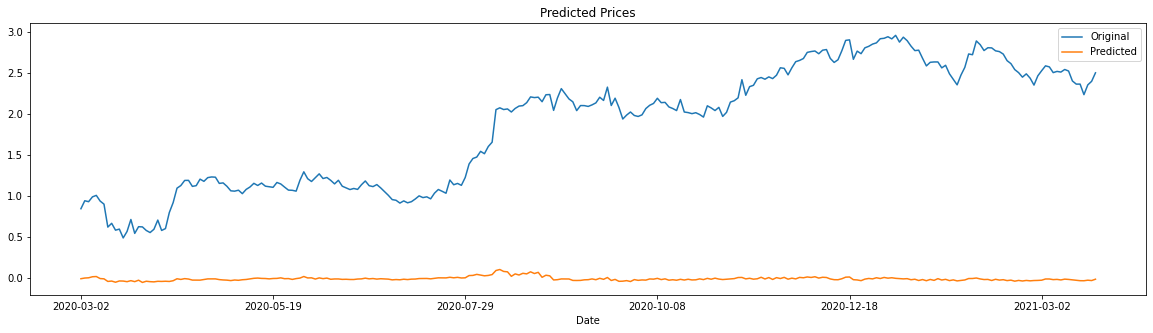

In [ ]:
ax = ScriptWiseData[stocks[1]][start_date:end_date].Close.plot(figsize=(20, 5), title="S&P 500 Prices", legend = True)
df_pred.plot(title="Predicted Prices", legend = True)
ax.legend(['Original', 'Predicted'])
plt.show()

# SARIMAX MODEL

In [ ]:
def SARIMAXProcedure(stockCode):
    # decompose
    data = ScriptWiseData  [stockCode]
    data.index = pd.to_datetime(data.index)
    data=data.asfreq('b')
    data = data.fillna(method='ffill')
    decompose_result = seasonal_decompose(data['Close'], model='add')
    
    r = auto_arima(data['Close'], exogenous=data[TechnicalIndicators], maxiter=1000) #seasonality, m parameters pending
    p, d, q = r.order # define for P, D, Q, S
        
    train, test = TrainTestSplitByDateRange(data)
    
    model = SARIMAX(train['Close'], exog = train[TechnicalIndicators] ,order = (p, d, q), seasonal_order = (1,1,1,2), enforce_invertibility = False)
    results = model.fit()
    predictions = results.predict(start_date, end_date, exog=test[TechnicalIndicators]).rename('SARIMA')
    
    return decompose_result, results, predictions

In [ ]:
decompose_result, model, predictions = SARIMAXProcedure(stocks[2])

### VARMAX MODEL

In [ ]:
def DifferenceToMakeStationary(data, n):
    data_transformed = data
    for i in range(n):
        data_transformed = data_transformed.diff()
    data_transformed = data_transformed.dropna()
    return data_transformed

In [ ]:
def InvertDifferencingForActualResults(data,data_differenced, forecast, column, order):
    df_forecast = forecast.copy()
    n = len(forecast)
    for i in range(order):
        tempColumn = f'{column}{i}'
        # Add the most recent first difference from the training side of the original dataset to the forecast cumulative sum
        df_forecast[tempColumn] = (data[column].iloc[-n-1]-data[column].iloc[-n-2]) + df_forecast[column].cumsum()
        # Now build the forecast values from the first difference set
        df_forecast['Forecast'] = df[column].iloc[-n-1] + df_forecast[tempColumn].cumsum()

In [ ]:
# Train and fit varmax model
def VARMAXProcedure(stockSymbol):
    data = ScriptWiseData[stockSymbol][['Close']+TechnicalIndicators] #.reset_index();
    data.index.freq = 'B'
    # determine values of p,d, q by auto arima.
    p, d, q = CalculateAutoArima(stockSymbol, ScriptWiseData[stockSymbol])
    
    # make data stationary based on auto arima output
    data_transformed = DifferenceToMakeStationary(data, d)
    
    # train test spllit  
    train, test = TrainTestSplitByDateRange(data_transformed)
    
    # fit the model based on above parameters
    model = VARMAX(train, order=(p,q))
    results = model.fit(maxiter=1000, disp=False)
    forecasts = results.forecast(len(test))
    
    #     forecasts = InvertDifferencingForActualResults()
    return results, forecasts

In [ ]:
# model, forecasts = VARMAXProcedure(stocks[0])

## Prophet models

In [ ]:
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

df_start_date = pd.to_datetime(start_date)
df_end_date = pd.to_datetime(end_date)

In [ ]:
def ProphetProcedure(stockCode, start_date = start_date, end_date = end_date):
    df = ScriptWiseData[stockCode]
    df.index = pd.to_datetime(df.index)
    df = df.reset_index()
    
    df.columns = ['ds', 'y'] + TechnicalIndicators
    
    test_start_date = pd.to_datetime(start_date)
    test_end_date = pd.to_datetime(end_date)
    
    train = df.loc[df.ds<df_start_date]
    test = df.loc[df.ds>=df_start_date]
#     return df, 1
    m = Prophet()
    for t in TechnicalIndicators:
        m.add_regressor(t)
    m.fit(train)
    future = m.make_future_dataframe(periods = len(test)-1, freq = "B")
    test_t = test.set_index('ds')
    future = future.set_index('ds')
    future = test_t[TechnicalIndicators].join(future).reset_index()
    forecast = m.predict(future)
    
        # initial
    initial = str(5*365)+' days'

    #period
    period = str(5*365)+' days'

    #horizon
    horizon = str(365) + ' days'
    df_cv = cross_validation(m, initial = initial, period = period, horizon = horizon)
    
    return m, forecast, df_cv

In [ ]:
# for plotting
df = ScriptWiseData[stocks[1]]
df.index = pd.to_datetime(df.index)
df = df.reset_index()

df.columns = ['ds', 'y'] + TechnicalIndicators

In [ ]:
m, forecast, df_cv = ProphetProcedure(stocks[1])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 3 forecasts with cutoffs between 2009-03-02 00:00:00 and 2019-02-28 00:00:00


  0%|          | 0/3 [00:00<?, ?it/s]

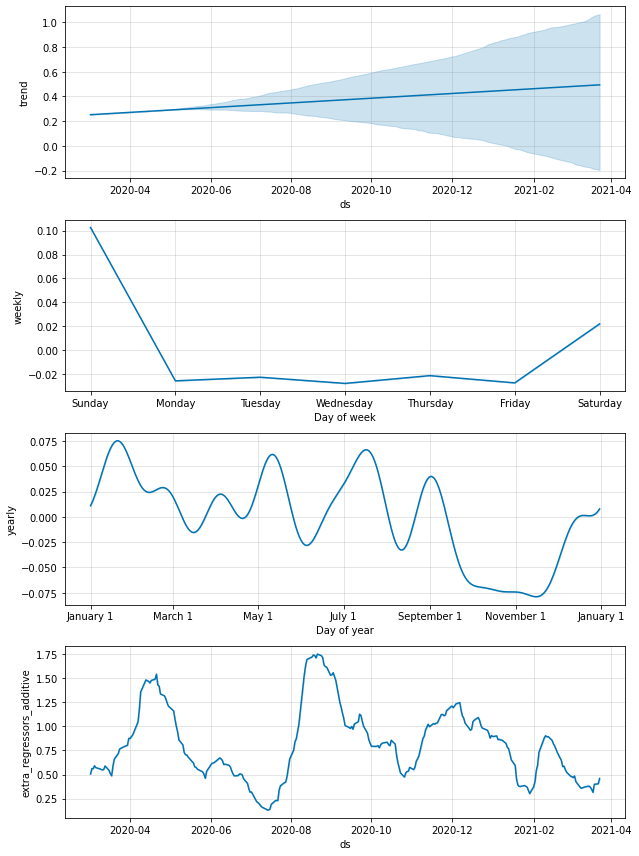

In [ ]:
m.plot_components(forecast);

<AxesSubplot:xlabel='ds'>

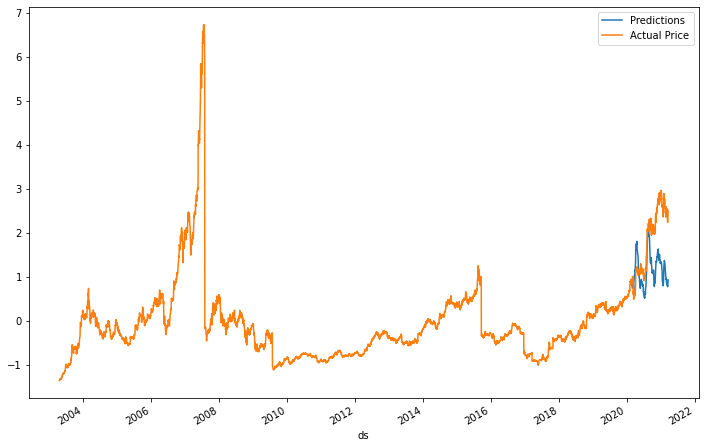

In [ ]:
ax = forecast.plot(x='ds',y='yhat',label='Predictions',legend=True,figsize=(12,8))

df.plot(x='ds',y='y',label='Actual Price',legend=True,ax=ax) #,xlim=(df_start_date,df_end_date))

In [ ]:
performance_metrics(df_cv).head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,37 days,0.114719,0.338702,0.277108,7.492858,1.533347,0.671233
1,38 days,0.113645,0.337113,0.275595,7.486203,1.533347,0.678082
2,39 days,0.116928,0.341947,0.281506,7.550378,1.541120,0.671233
3,40 days,0.122010,0.349300,0.290183,7.585741,1.555269,0.657534
4,41 days,0.127399,0.356931,0.298839,7.609144,1.555269,0.643836


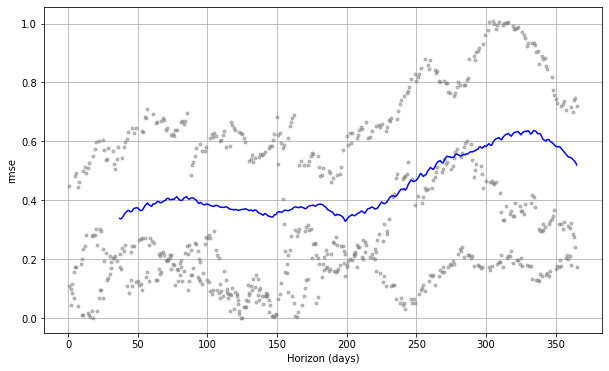

In [ ]:
plot_cross_validation_metric(df_cv, metric='rmse');

## Neural Prophet and AR-Net

In [ ]:
from neuralprophet import NeuralProphet, set_random_seed , set_log_level
set_random_seed(0)
set_log_level("ERROR")

In [ ]:
df = ScriptWiseData['BOM500180'].reset_index()
df = df[['Date', 'Close']]
df.columns = ['ds', 'y']
df.head()

,ds,y
0,2000-02-10,-1.193633
1,2000-02-11,-1.225195
2,2000-02-14,-1.220393
3,2000-02-15,-1.225116
4,2000-02-16,-1.196073


### Basic Model

In [ ]:
def BuildNeuralProphetModels(dataset, start_date = start_date, end_date = end_date, n_forecasts = 1, n_lags = 5):
    # prepare the dataset
    df = dataset.reset_index()
    df = df[['Date', 'Close']]
    df.columns = ['ds', 'y']
    
    # train test splilt
    train = df.loc[(df['ds'] < start_date)]
    df_test = df.loc[(df['ds'] >= start_date) & (df['ds'] <= end_date)]
    
    # initalize the model
    m = NeuralProphet(n_forecasts=n_forecasts,n_lags=n_lags)
    
    # split the training set into train and validation set
    df_train, df_val = m.split_df(train, valid_p=0.2, freq='D')

    # fit and test the model
    train_metrics = m.fit(df_train, freq='D')
    val_metrics = m.test(df_val)
    
    # make forecasts
    future = m.make_future_dataframe(df_test, periods=len(df_test), n_historic_predictions=len(df_test))
#     future = m.make_future_dataframe(df_test, n_historic_predictions= True)
    forecast = m.predict(future)
    return (m, forecast,  train_metrics, val_metrics)

In [ ]:
# m = NeuralProphet()
# metrics = m.fit(df, freq="D")
m, forecast , train_metrics, val_metrics = BuildNeuralProphetModels(ScriptWiseData['BOM500180'])

  0%|          | 0/288 [00:00<?, ?it/s]

#### Plot the forecast

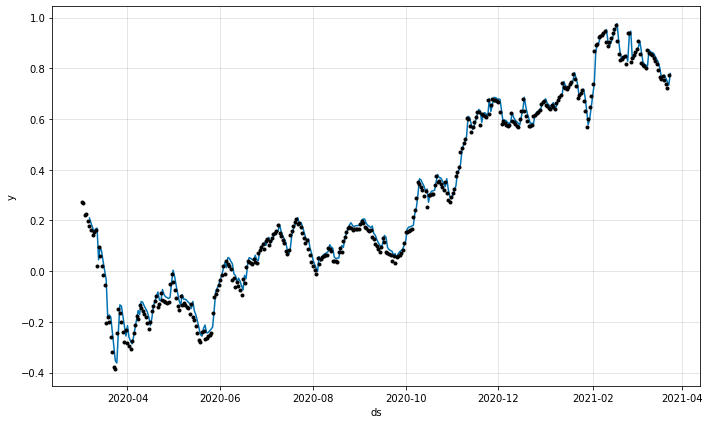

In [ ]:
forecasts_plot = m.plot(forecast)

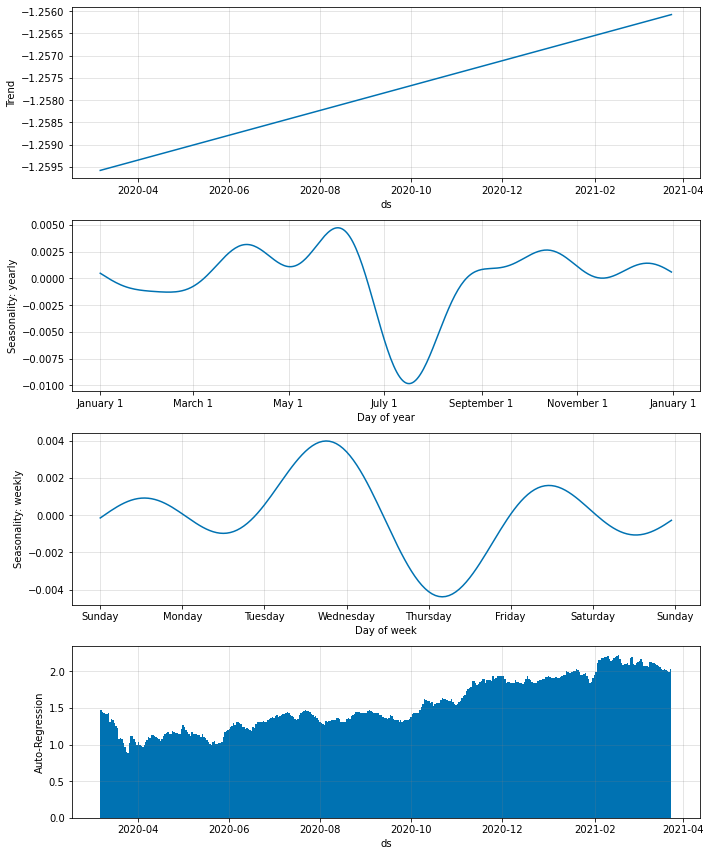

In [ ]:
fig_comp = m.plot_components(forecast);

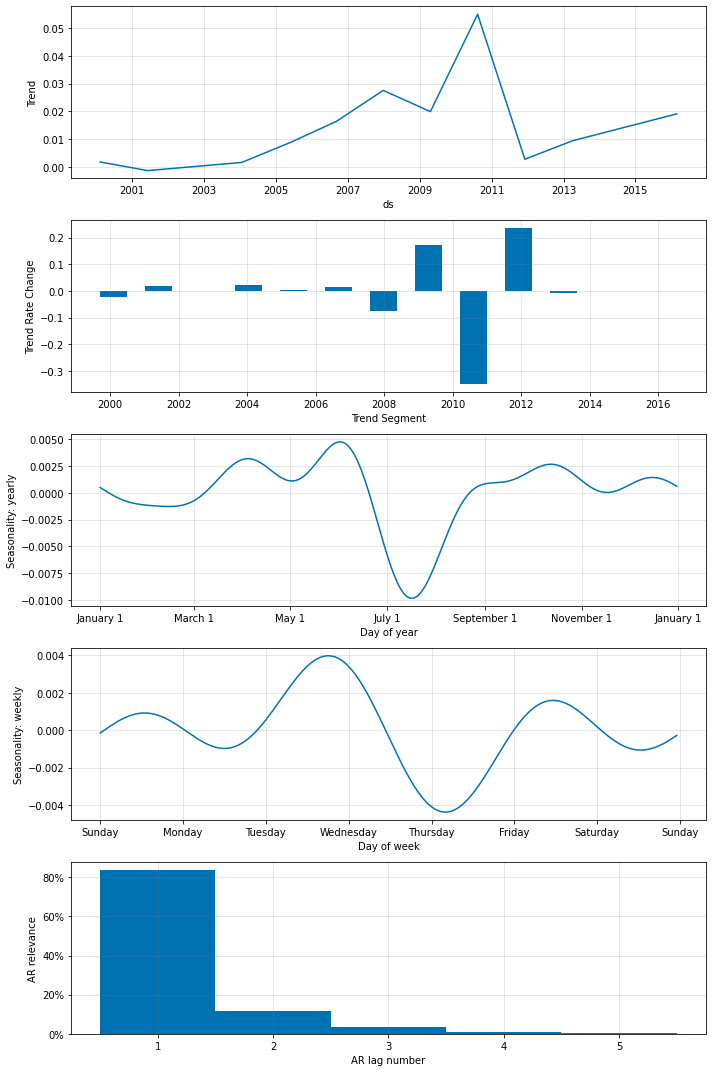

In [ ]:
fig_param = m.plot_parameters()

#### Validating the dataset

In [ ]:
m = NeuralProphet()
df_train, df_val = m.split_df(df, valid_p=0.2, freq='D')

In [ ]:
train_metrics = m.fit(df_train, freq='D')
val_metrics = m.test(df_val)

  0%|          | 0/281 [00:00<?, ?it/s]

## Multiple regressors

In [ ]:
def BuildNeuralProphetModelsWithMultipleRegressors(dataset, start_date = start_date, end_date = end_date, n_forecasts = 1, n_lags = 5):
    # prepare the dataset
    df = dataset.reset_index()
    df = df[['Date', 'Close']+TechnicalIndicators]
    df.columns = ['ds', 'y', 'A', 'B', 'C', 'D', 'E']
    
    # train test splilt
    train = df.loc[(df['ds'] < start_date)]
    df_test = df.loc[(df['ds'] >= start_date) & (df['ds'] <= end_date)]
    
    # initalize the model
    m = NeuralProphet(n_forecasts=n_forecasts,n_lags=n_lags)
    # lagged regressors
    m.add_lagged_regressor(name='A')
    m.add_lagged_regressor(name='B')
    m.add_lagged_regressor(name='C')
    m.add_lagged_regressor(name='D')
    m.add_lagged_regressor(name='E')
    
    # split the training set into train and validation set
    df_train, df_val = m.split_df(train, valid_p=0.2, freq='D')

    # fit and test the model
    train_metrics = m.fit(df_train, freq='D')
    val_metrics = m.test(df_val)
    
    # make forecasts
    # future = m.make_future_dataframe(df_test, periods=len(df_test), n_historic_predictions=len(df_test))
    future = m.make_future_dataframe(df_test, n_historic_predictions= True)
    forecast = m.predict(future)
    return (m, forecast,  train_metrics, val_metrics)

  0%|          | 0/288 [00:00<?, ?it/s]

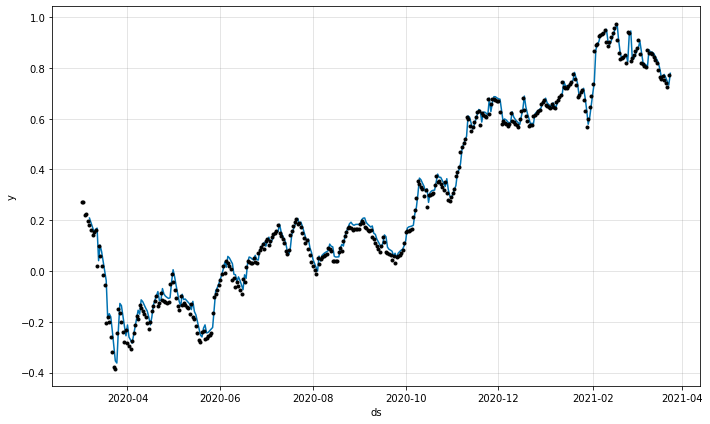

In [ ]:
m, forecast , train_metrics, val_metrics = BuildNeuralProphetModels(ScriptWiseData['BOM500180'])
forecasts_plot = m.plot(forecast)

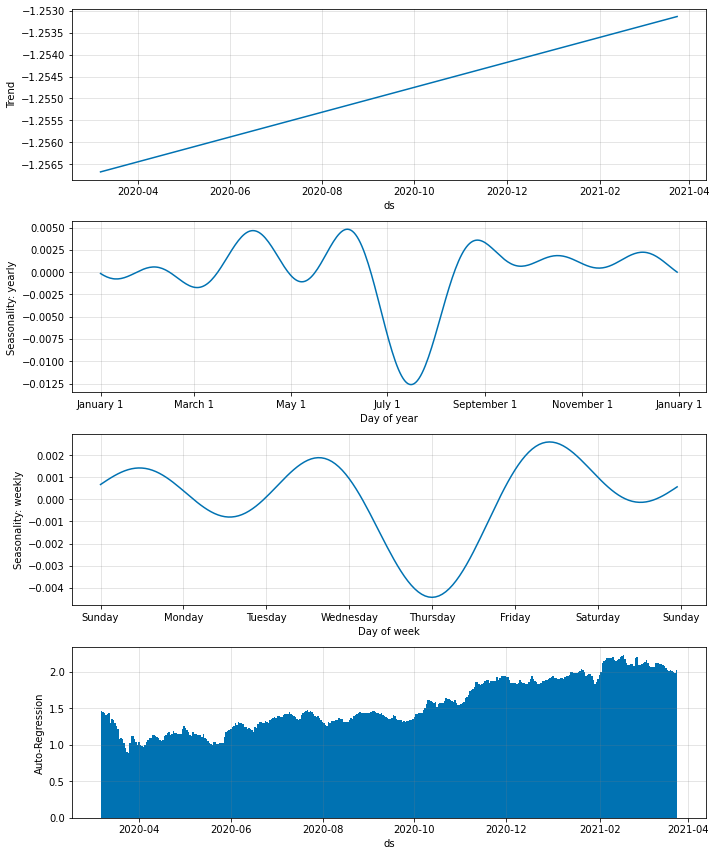

In [ ]:
fig_comp = m.plot_components(forecast)

In [ ]:
train_metrics.sort_values(by=['MAE', 'MSE'], ascending = [False, False]).head(3)

,SmoothL1Loss,MAE,MSE,RegLoss
0,0.555061,2.861128,13.603557,0.0
22,0.090423,1.018086,1.713373,0.0
30,0.089824,1.004676,1.698754,0.0


In [ ]:
train_metrics.sort_values(by=['MAE', 'MSE'], ascending = [True, True]).head(3)

,SmoothL1Loss,MAE,MSE,RegLoss
77,0.000121,0.014934,0.002257,0.0
76,0.000121,0.015009,0.002271,0.0
74,0.000127,0.016852,0.002372,0.0


In [ ]:
val_metrics

,SmoothL1Loss,MAE,MSE
0,0.000138,0.019459,0.002574
